# Funny Dog Image Segmentation

In [1]:
# install dependencies:
!pip install pyyaml
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.2.1+cu121 True


In [2]:
# clone the repo in order to access pre-defined configs in PointRend project
!git clone --branch v0.6 https://github.com/facebookresearch/detectron2.git detectron2_repo
# install detectron2 from source
!pip install -e detectron2_repo --quiet
# See https://detectron2.readthedocs.io/tutorials/install.html for other installation options

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15526, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 15526 (delta 80), reused 195 (delta 54), pack-reused 15275
Receiving objects: 100% (15526/15526), 6.40 MiB | 16.67 MiB/s, done.
Resolving deltas: 100% (11194/11194), done.
Note: switching to 'd1e04565d3bec8719335b88be9e9b961bf3ec464'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
coco_metadata = MetadataCatalog.get("coco_2017_val")

# import PointRend project
from detectron2.projects import point_rend

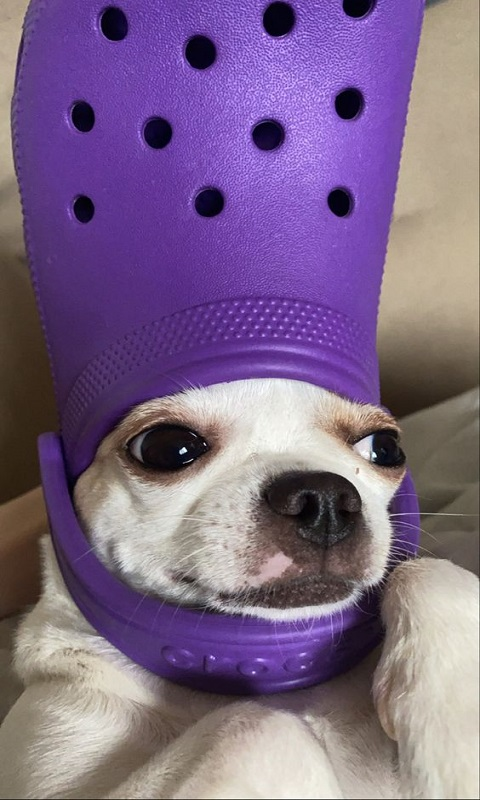

In [2]:
!wget https://m.media-amazon.com/images/I/61DK+ex803L.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [3]:
cfg = get_cfg()
# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
# Load a config from file
cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Use a model from PointRend model zoo: https://github.com/facebookresearch/detectron2/tree/master/projects/PointRend#pretrained-models
cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_edd263.pkl: 241MB [00:03, 77.3MB/s]                          


WARNING [03/31 12:53:13 d2.projects.point_rend.mask_head]: Weight format of PointRend models have changed! Applying automatic conversion now ...


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Mask R-CNN with PointRend (top)     vs.     Default Mask R-CNN (bottom)


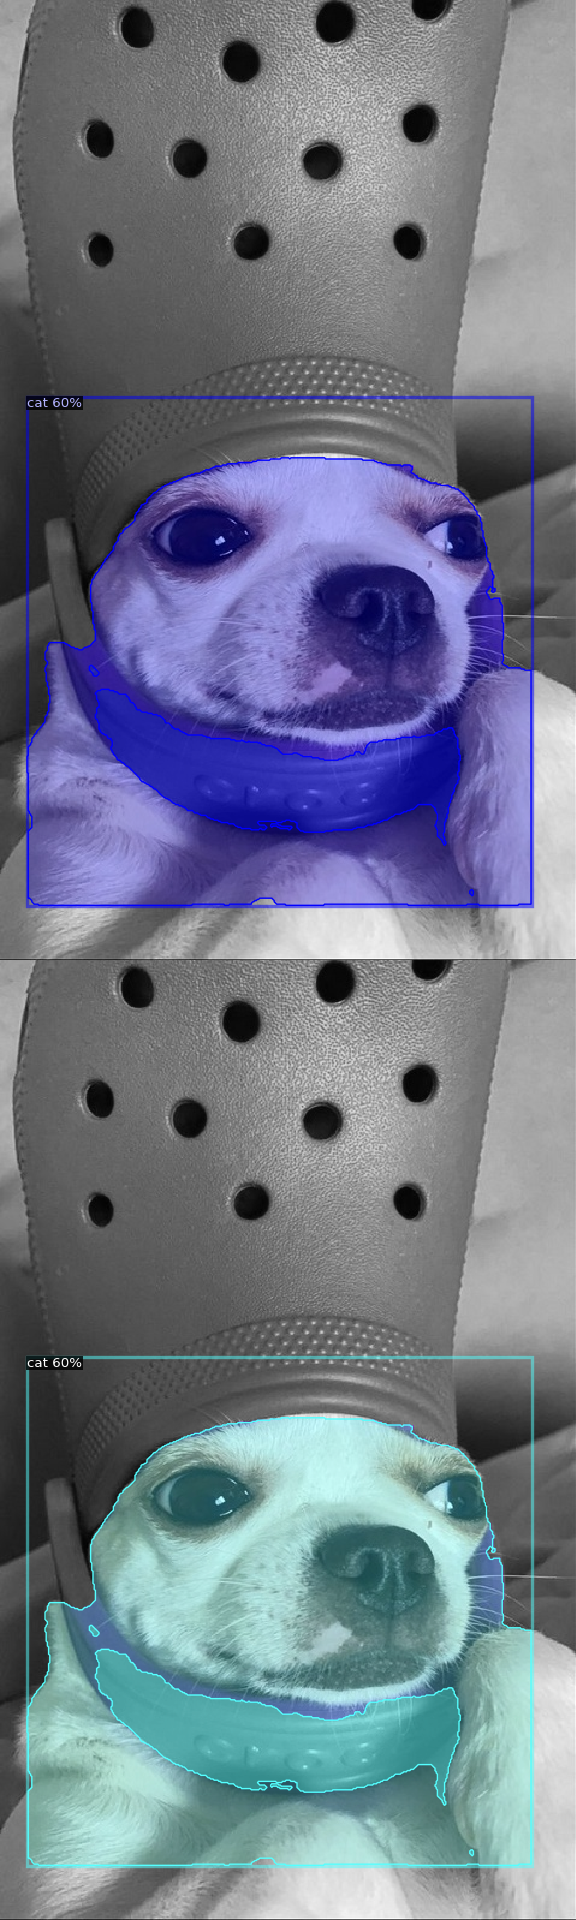

In [4]:
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
mask_rcnn_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
point_rend_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
print("Mask R-CNN with PointRend (top)     vs.     Default Mask R-CNN (bottom)")
cv2_imshow(np.concatenate((point_rend_result, mask_rcnn_result), axis=0)[:, :, ::-1])

# Troubleshooting during code block above


Image shape before any operation: (100, 100, 3)
Image shape after concatenation: (100, 100, 3)
Final image shape to display: (100, 100, 3)


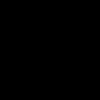

In [5]:
import numpy as np

# Example variable for demonstration, replace with your actual image variable
point_rend_result = np.random.rand(100, 100, 3)  # This should be your image data

# Check the shape of the image data
print("Image shape before any operation:", point_rend_result.shape)

# If concatenating, ensure the axis is correct (0 for vertical, 1 for horizontal)
concatenated_image = np.concatenate((point_rend_result,), axis=0)  # Single tuple for one image

print("Image shape after concatenation:", concatenated_image.shape)

# Ensure color channels are correct (use [::-1] if the image is RGB and you need BGR for OpenCV)
image_to_display = concatenated_image[..., ::-1] if concatenated_image.ndim == 3 else concatenated_image

print("Final image shape to display:", image_to_display.shape)

# Display the image
from google.colab.patches import cv2_imshow
cv2_imshow(image_to_display)

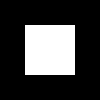

In [6]:
import numpy as np
from google.colab.patches import cv2_imshow

# Generate a test image with known content
test_image = np.zeros((100, 100, 3), dtype=np.uint8)

# Draw a white square in the center
test_image[25:75, 25:75] = 255  # white square

# Display the test image
cv2_imshow(test_image)

# Point sampling Process

In [7]:
# First we define a simple function to help us plot the intermediate representations.
import matplotlib.pyplot as plt

def plot_mask(mask, title="", point_coords=None, figsize=10, point_marker_size=5):
  '''
  Simple plotting tool to show intermediate mask predictions and points
  where PointRend is applied.

  Args:
    mask (Tensor): mask prediction of shape HxW
    title (str): title for the plot
    point_coords ((Tensor, Tensor)): x and y point coordinates
    figsize (int): size of the figure to plot
    point_marker_size (int): marker size for points
  '''

  H, W = mask.shape
  plt.figure(figsize=(figsize, figsize))
  if title:
    title += ", "
  plt.title("{}resolution {}x{}".format(title, H, W), fontsize=30)
  plt.ylabel(H, fontsize=30)
  plt.xlabel(W, fontsize=30)
  plt.xticks([], [])
  plt.yticks([], [])
  plt.imshow(mask, interpolation="nearest", cmap=plt.get_cmap('gray'))
  if point_coords is not None:
    plt.scatter(x=point_coords[0], y=point_coords[1], color="red", s=point_marker_size, clip_on=True)
  plt.xlim(-0.5, W - 0.5)
  plt.ylim(H - 0.5, - 0.5)
  plt.show()

<ipython-input-8-897f654a69fc>:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  batched_inputs = [{"image": torch.as_tensor(im_transformed).permute(2, 0, 1)}]


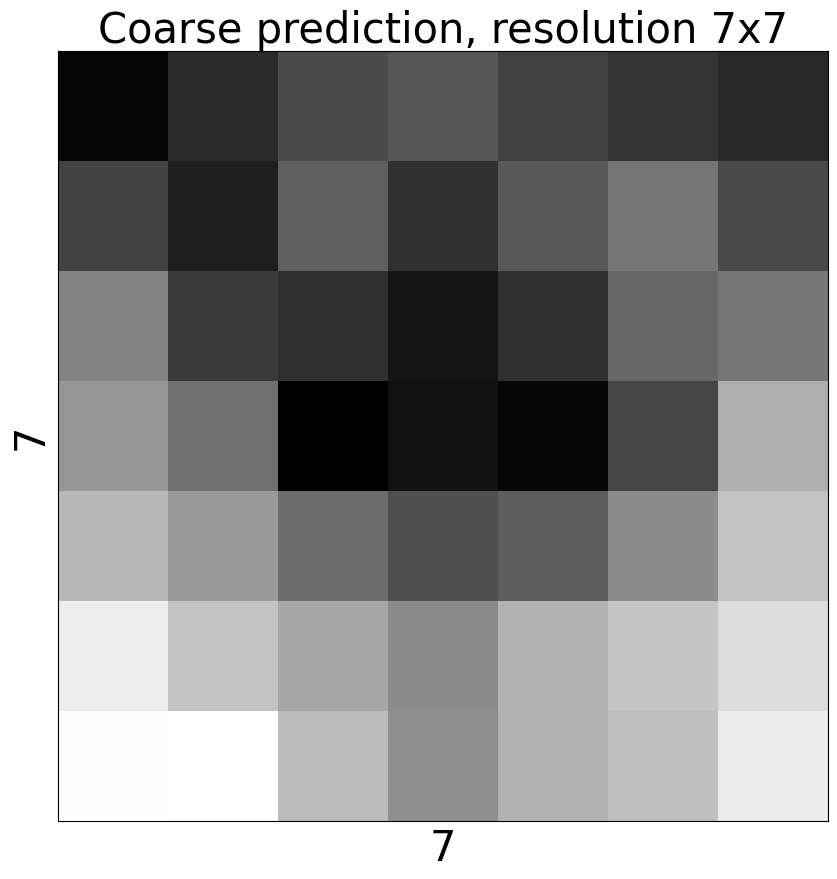

In [8]:
from detectron2.data import transforms as T
model = predictor.model
# In this image we detect several objects but show only the first one.
instance_idx = 0
# Mask predictions are class-specific, "plane" class has id 4.
category_idx = 4

with torch.no_grad():
  # Prepare input image.
  height, width = im.shape[:2]
  im_transformed = T.ResizeShortestEdge(800, 1333).get_transform(im).apply_image(im)
  batched_inputs = [{"image": torch.as_tensor(im_transformed).permute(2, 0, 1)}]

  # Get bounding box predictions first to simplify the code.
  detected_instances = [x["instances"] for x in model.inference(batched_inputs)]
  [r.remove("pred_masks") for r in detected_instances]  # remove existing mask predictions
  pred_boxes = [x.pred_boxes for x in detected_instances]

  # Run backbone.
  images = model.preprocess_image(batched_inputs)
  features = model.backbone(images.tensor)

  # Given the bounding boxes, run coarse mask prediction head.
  mask_coarse_logits = model.roi_heads.mask_head.coarse_head(model.roi_heads.mask_head._roi_pooler(features, pred_boxes))

  plot_mask(
      mask_coarse_logits[instance_idx, category_idx].to("cpu"),
      title="Coarse prediction"
  )


In [9]:
# Prepare features maps to use later
mask_features_list = [
  features[k] for k in model.roi_heads.mask_head.mask_point_in_features
]
features_scales = [
  model.roi_heads.mask_head._feature_scales[k]
  for k in model.roi_heads.mask_head.mask_point_in_features
]

## Point sampling during training


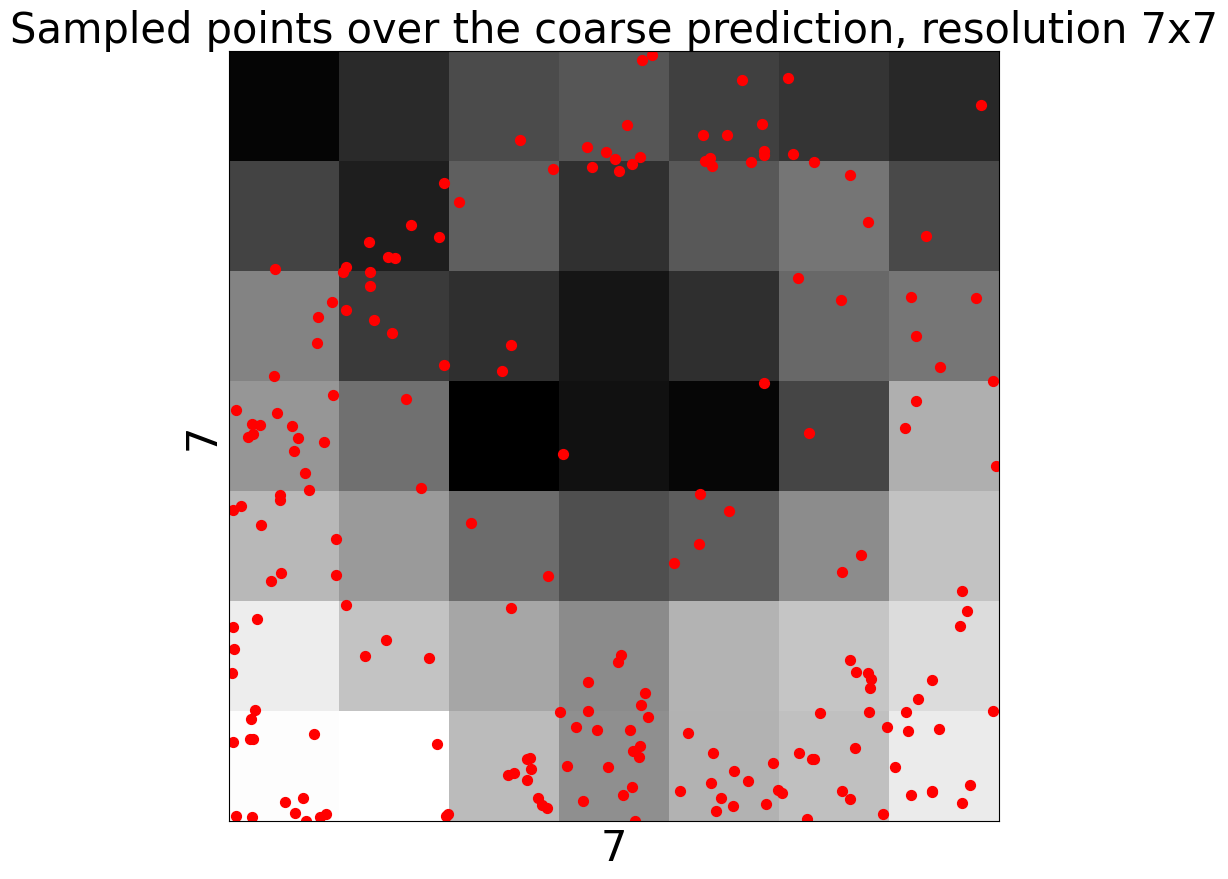

In [10]:
from detectron2.projects.point_rend.mask_head import calculate_uncertainty
from detectron2.projects.point_rend.point_features import get_uncertain_point_coords_with_randomness

# Change number of points to select
num_points = 14 * 14
# Change randomness parameters
oversample_ratio = 3  # `k` in the paper
importance_sample_ratio = 0.75  # `\beta` in the paper

with torch.no_grad():
  # We take predicted classes, whereas during real training ground truth classes are used.
  pred_classes = torch.cat([x.pred_classes for x in detected_instances])

  # Select points given a corse prediction mask
  point_coords = get_uncertain_point_coords_with_randomness(
    mask_coarse_logits,
    lambda logits: calculate_uncertainty(logits, pred_classes),
    num_points=num_points,
    oversample_ratio=oversample_ratio,
    importance_sample_ratio=importance_sample_ratio
  )

  H, W = mask_coarse_logits.shape[-2:]
  plot_mask(
    mask_coarse_logits[instance_idx, category_idx].to("cpu"),
    title="Sampled points over the coarse prediction",
    point_coords=(
      W * point_coords[instance_idx, :, 0].to("cpu") - 0.5,
      H * point_coords[instance_idx, :, 1].to("cpu") - 0.5
    ),
    point_marker_size=50
  )

During interference


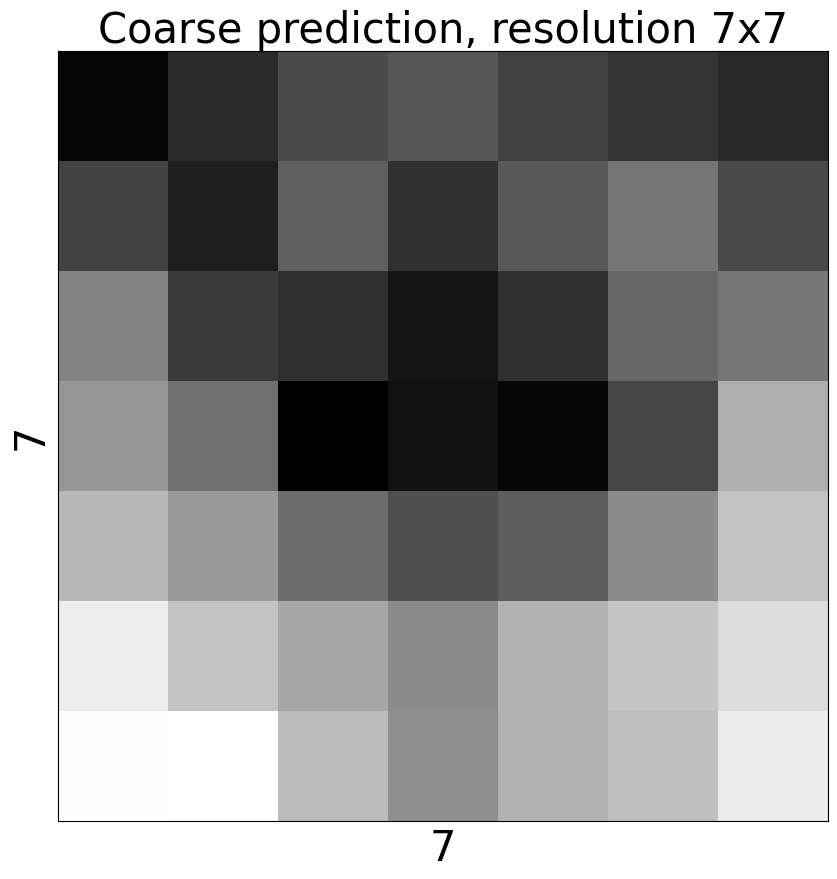

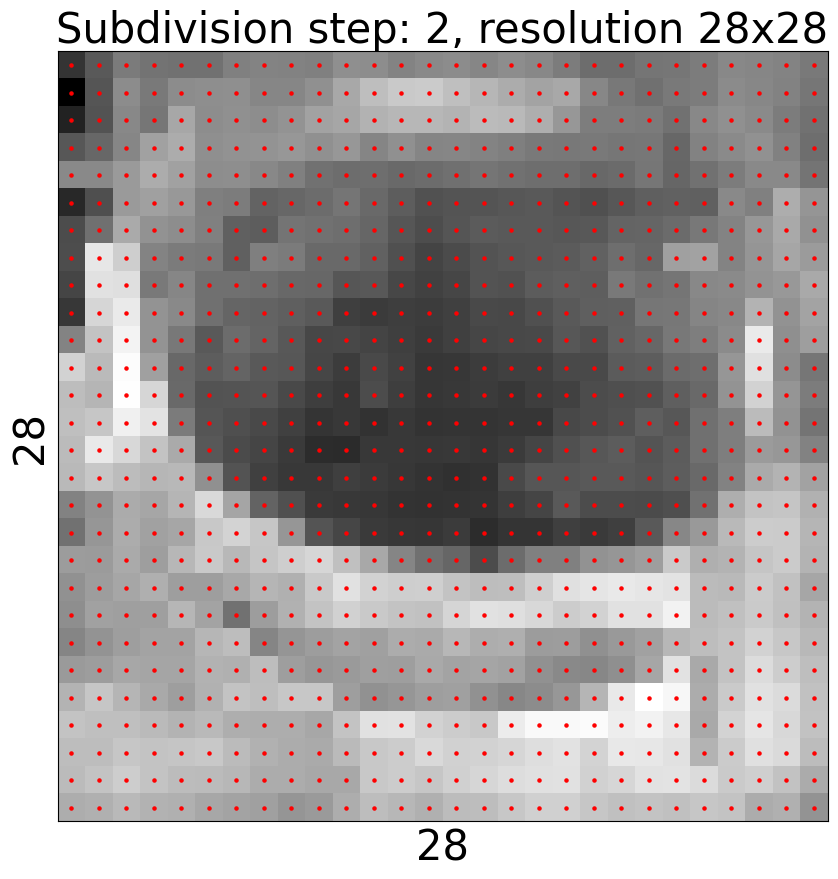

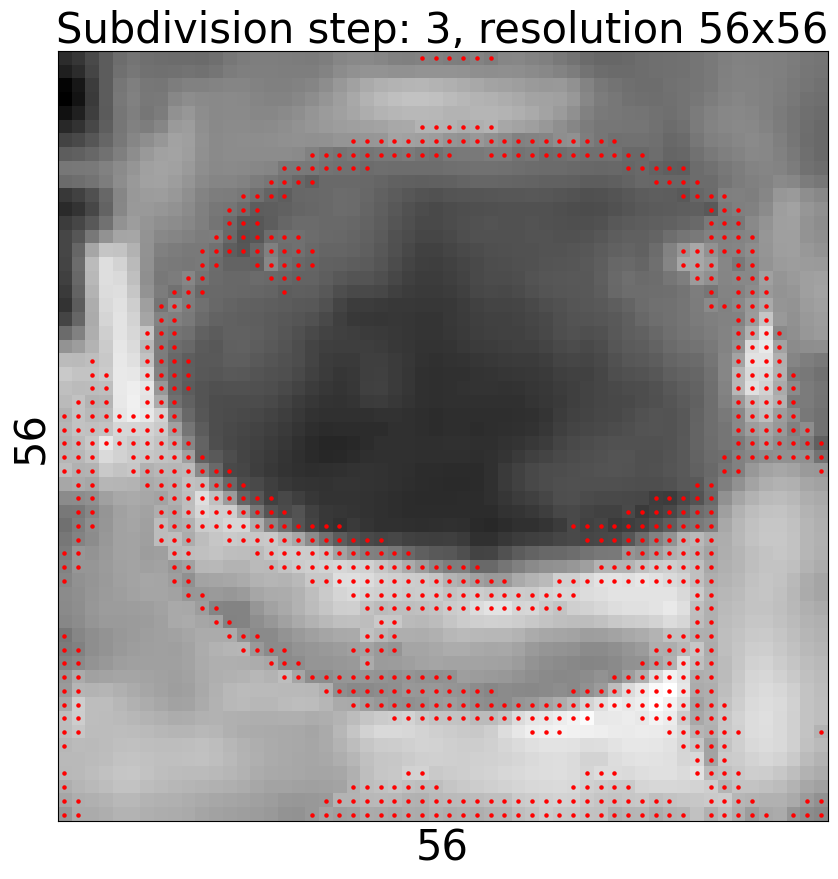

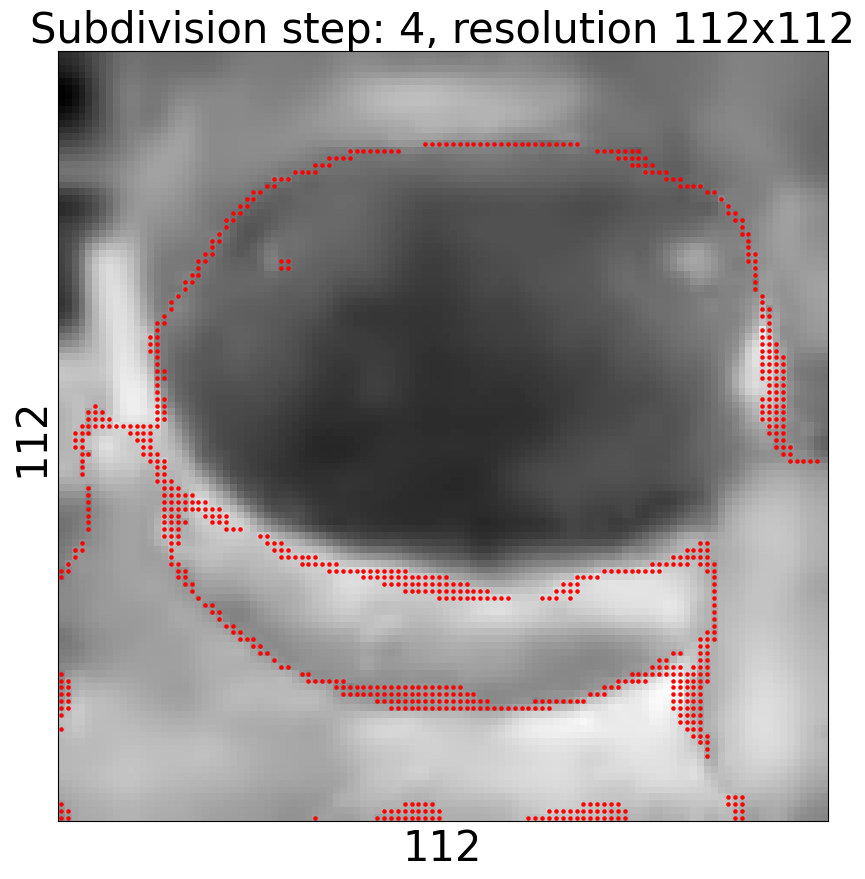

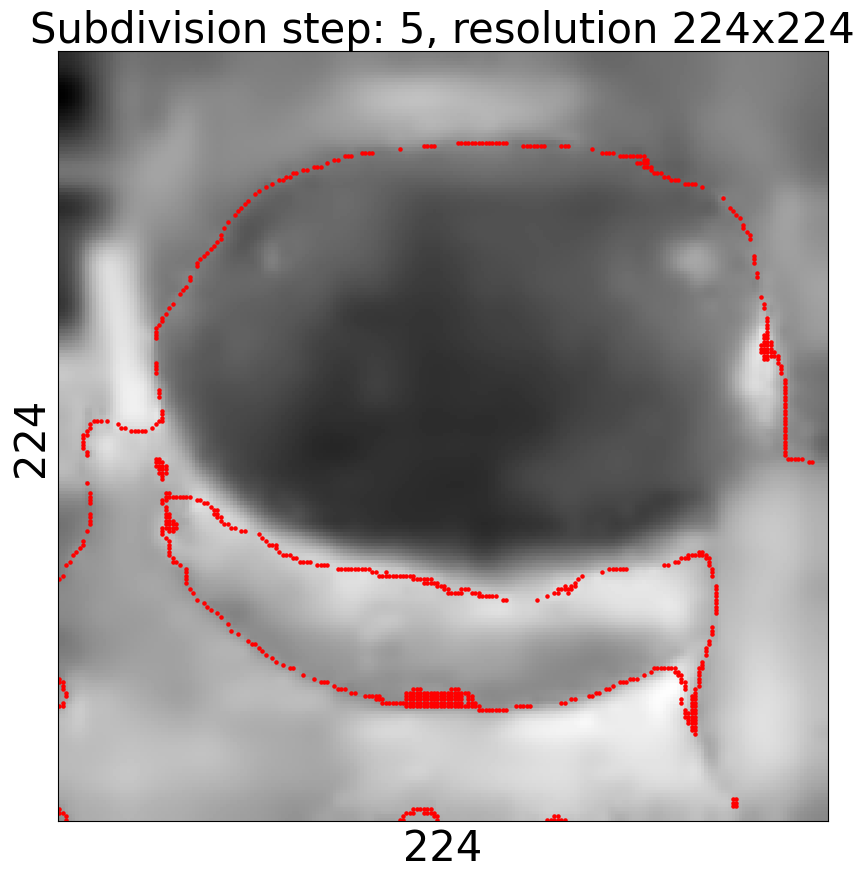

In [11]:
from detectron2.layers import interpolate
from detectron2.projects.point_rend.mask_head import calculate_uncertainty
from detectron2.projects.point_rend.point_features import (
    get_uncertain_point_coords_on_grid,
    point_sample,
    point_sample_fine_grained_features,
)

num_subdivision_steps = 5
num_subdivision_points = 28 * 28


with torch.no_grad():
  plot_mask(
      mask_coarse_logits[0, category_idx].to("cpu").numpy(),
      title="Coarse prediction"
  )

  mask_logits = mask_coarse_logits
  for subdivions_step in range(num_subdivision_steps):
    # Upsample mask prediction
    mask_logits = interpolate(
        mask_logits, scale_factor=2, mode="bilinear", align_corners=False
    )
    # If `num_subdivision_points` is larger or equalt to the
    # resolution of the next step, then we can skip this step
    H, W = mask_logits.shape[-2:]
    if (
      num_subdivision_points >= 4 * H * W
      and subdivions_step < num_subdivision_steps - 1
    ):
      continue
    # Calculate uncertainty for all points on the upsampled regular grid
    uncertainty_map = calculate_uncertainty(mask_logits, pred_classes)
    # Select most `num_subdivision_points` uncertain points
    point_indices, point_coords = get_uncertain_point_coords_on_grid(
        uncertainty_map,
        num_subdivision_points
    )

    # Extract fine-grained and coarse features for the points
    fine_grained_features, _ = point_sample_fine_grained_features(
      mask_features_list, features_scales, pred_boxes, point_coords
    )
    coarse_features = point_sample(mask_coarse_logits, point_coords, align_corners=False)

    # Run PointRend head for these points
    point_logits = model.roi_heads.mask_head.point_head(fine_grained_features, coarse_features)

    # put mask point predictions to the right places on the upsampled grid.
    R, C, H, W = mask_logits.shape
    x = (point_indices[instance_idx] % W).to("cpu")
    y = (point_indices[instance_idx] // W).to("cpu")
    point_indices = point_indices.unsqueeze(1).expand(-1, C, -1)
    mask_logits = (
      mask_logits.reshape(R, C, H * W)
      .scatter_(2, point_indices, point_logits)
      .view(R, C, H, W)
    )
    plot_mask(
      mask_logits[instance_idx, category_idx].to("cpu"),
      title="Subdivision step: {}".format(subdivions_step + 1),
      point_coords=(x, y)
    )

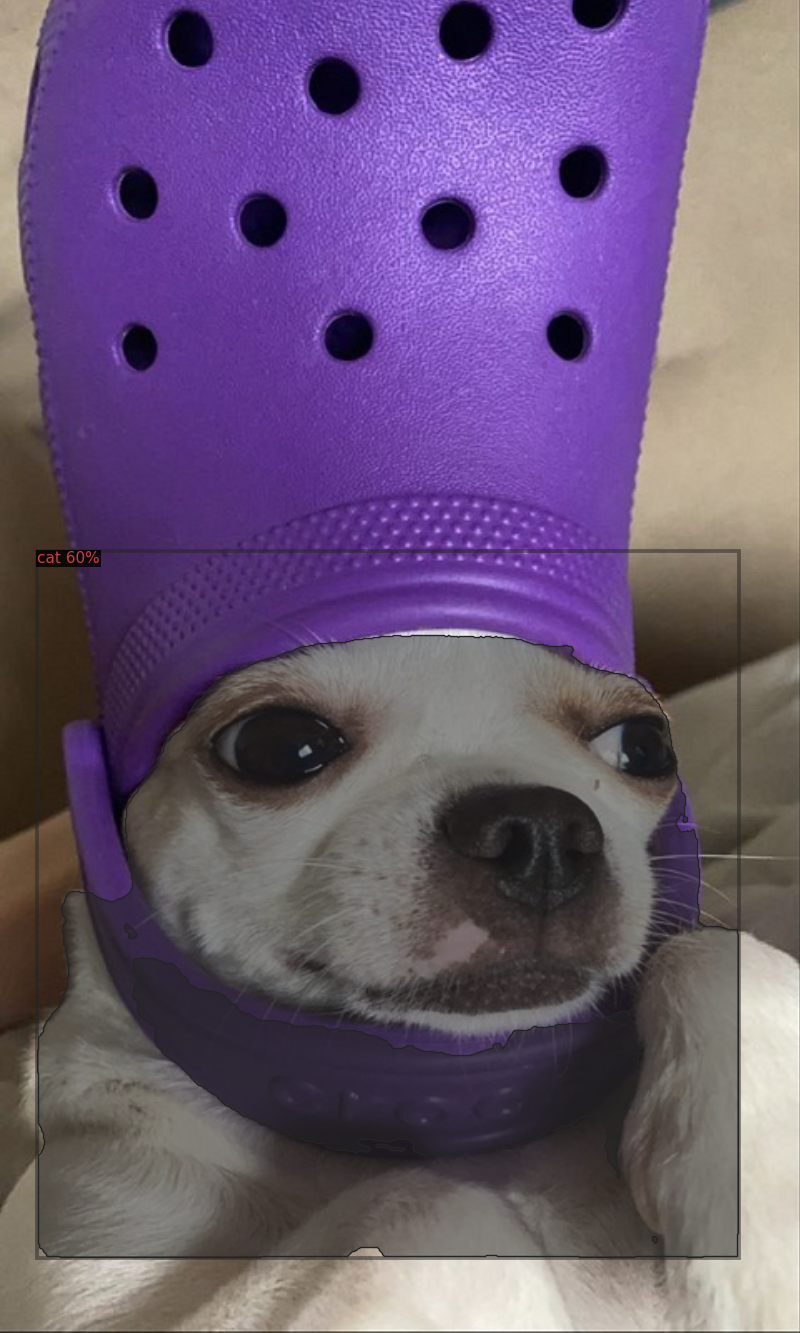

In [12]:
from detectron2.modeling import GeneralizedRCNN
from detectron2.modeling.roi_heads.mask_head import mask_rcnn_inference

results = detected_instances
mask_rcnn_inference(mask_logits, results)
results = GeneralizedRCNN._postprocess(results, batched_inputs, images.image_sizes)[0]

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im_transformed[:, :, ::-1], coco_metadata)
v = v.draw_instance_predictions(results["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])